# Hostel Booking and Revenue Analysis

Hotel booking cancellations can significantly disrupt operations, leading to lost revenue and inefficient resource allocation. The goal is to build a predictive model that identifies the likelihood of a booking being cancelled, enabling proactive strategies such as overbooking, dynamic pricing, and targeted guest engagement.

**Dataset**: [Hotel Revenue 2024 - Kaggle](https://www.kaggle.com/datasets/omarsobhy14/hotel-revenue2024)

  

In [1]:
# libraries import
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.conf import SparkConf
from pyspark.sql.functions import col, count, when, isnan, sum as spark_sum

## 1. Load data

In [3]:
conf = SparkConf()

sc = SparkContext.getOrCreate(conf=conf)
sc.setLogLevel("ERROR")

spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Hotel Booking Cancellation Prediction") \
    .getOrCreate()

print(f"Spark Session created - Version: {spark.version}")
!python --version

Spark Session created - Version: 4.0.0
Python 3.11.2


In [4]:
data_path = "../data/raw/hotel-revenue-2024.csv"

df = spark.read.option("header", True)\
               .option("inferSchema", True)\
               .option("escape", "\"")\
               .csv(data_path)

total_rows = df.count()
total_columns = len(df.columns)
print(f"Dataset loaded: {total_rows} lines, {total_columns} columns")

Dataset loaded: 109 lines, 38 columns


## 2. Exploratory Data Analysis

In [5]:
df.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Weekday: integer (nullable = true)
 |-- Season: string (nullable = true)
 |-- Holiday: integer (nullable = true)
 |-- Marketing_Spend: integer (nullable = true)
 |-- Revenue: integer (nullable = true)
 |-- Room_Revenue: integer (nullable = true)
 |-- Occupancy_Rate: double (nullable = true)
 |-- ADR: integer (nullable = true)
 |-- RevPAR: double (nullable = true)
 |-- Available_Rooms: integer (nullable = true)
 |-- Reserved_Rooms: integer (nullable = true)
 |-- Booking_Channel: string (nullable = true)
 |-- Guest_Type: string (nullable = true)
 |-- Market_Segment: double (nullable = true)
 |-- Guest_Country: string (nullable = true)
 |-- Complaints: integer (nullable = true)
 |-- Compliment: integer (nullable = true)
 |-- Bookings: integer (nullable = true)
 |-- No_Shows: integer (nullable = true)
 |-- Cancellations: integer (nullable = true)
 |-- Checkouts: integer (nullable = true)
 |-- New_Bookings: 

### Column details from the Kaggle documentation

- **Date:** The date of the recorded data.
- **Month:** Numeric representation of the month.
- **Day of the Week:** Numeric representation of the day in a week.
- **Season:** Categorical representation of the season (e.g., Winter, Spring, Summer, Fall).
- **Public Holiday:** Binary indicator (0 or 1) denoting whether it's a public holiday.
- **Previous Month Revenue:** Revenue generated in the previous month.
- **Year-over-Year Revenue:** Revenue compared to the same month the previous year.
- **Monthly Trend:** Trend in revenue or occupancy for the month.
- **Occupancy Rate:** Percentage of rooms occupied.
- **Average Daily Rate (ADR):** Average rate charged per occupied room.
- **Revenue per Available Room (RevPAR):** Revenue generated per available room.
- **Booking Lead Time:** Average lead time between booking and stay.
- **Booking Cancellations:** Percentage of bookings cancelled.
- **Booking Source:** Source of the booking (e.g., Direct, OTA).
- **Guest Type:** Type of guest (e.g., Leisure, Business).
- **Repeat Guests:** Percentage of guests who are repeat visitors.
- **Nationality:** Nationality of guests.
- **Group Bookings:** Binary indicator denoting group bookings.
- **Discounts and Promotions:** Use of discounts or promotions.
- **Room Rate:** Average rate charged for rooms.
- **Local Events:** Presence of local events influencing occupancy.
- **Hotel Events:** Events hosted by the hotel affecting operations.
- **Competitor Rates:** Rates offered by competitors.
- **Weather Conditions:** Local weather conditions influencing guest behavior.
- **Economic Indicators:** Economic factors influencing hotel performance.
- **Staff Levels:** Staffing levels affecting service quality.
- **Guest Satisfaction:** Guest satisfaction ratings.
- **Maintenance Issues:** Issues related to maintenance affecting operations.
- **Marketing Spend:** Expenditure on marketing activities.
- **Online Reviews:** Ratings and reviews provided online.
- **Social Media Engagement:** Engagement metrics on social media platforms.
- **Seasonal Adjustments:** Adjustments made for seasonal variations.
- **Trend Adjustments:** Adjustments made for trending factors.
- **Room Revenue:** Total revenue from room bookings.
- **Food and Beverage Revenue:** Revenue from food and beverage services.
- **Other Services Revenue:** Revenue from other hotel services.
- **Total Revenue for the Month:** Overall revenue generated for the month.

In [6]:
# Renaming columns for better understanding
cols_dict = {
    "Holiday": "Public_Holiday",
    "ADR": "Average_Daily_Rate",
    "Cancellations": "Booking_Cancellations",
    "Booking Source": "Booking_Channel",
}

for old_name, new_name in cols_dict.items():
    df = df.withColumnRenamed(old_name, new_name)

### Missing values

In [7]:
import builtins

total_cells = total_rows * total_columns

# Total number of nulls per column
null_counts = df.select([
    spark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
    for c in df.columns
]).collect()[0].asDict()

# Total number of nulls in DataFrame
total_nulls = builtins.sum(null_counts.values())

# Global missing value percentage
missing_pct_global = (total_nulls / total_cells) * 100

print(f"Total missing values: {total_nulls}")
print(f"Global missing percentage: {missing_pct_global:.2f}%")

Total missing values: 109
Global missing percentage: 2.63%


In [8]:
# Get columns with missing values
missing_by_column = {
    col_name: {
        'missing_count': count,
        'missing_pct': (count / df.count()) * 100
    }
    for col_name, count in null_counts.items()
    if count > 0
}
missing_by_column

{'Profit': {'missing_count': 109, 'missing_pct': 100.0}}

In [35]:
from pyspark.sql.functions import col, count, when, isnan
from pyspark.sql.types import FloatType, DoubleType

def missing_columns_typed(df):
    total_rows = df.count()
    result_exprs = []
    schema = dict(df.dtypes)

    for c in df.columns:
        dtype = schema[c]
        if dtype in ['float', 'double']:
            # For floating-point numeric types, include isnan
            expr = (count(when(col(c).isNull() | isnan(col(c)), c)) / total_rows).alias(c)
        else:
            # For other types, only isNull
            expr = (count(when(col(c).isNull(), c)) / total_rows).alias(c)

        result_exprs.append(expr)

    # Percent
    missing_stats = df.select(result_exprs)
    missing_dict = missing_stats.first().asDict()

    # Filter columns with missing values
    filtered = {k: v for k, v in missing_dict.items() if v > 0}

    return filtered
    
missing_columns_typed(df)

{'Profit': 1.0}

### Duplicated values

In [9]:
duplicates = df.groupBy(df.columns) \
               .agg(count("*").alias("count")) \
               .filter("count > 1")

print(f"Duplicated rows : {duplicates.count()}")

Duplicated rows : 0


### Values types

In [10]:
num_categorical = 0
num_numerical = 0

for field in df.schema.fields:
    dtype = field.dataType.simpleString()
    if dtype in ['string', 'boolean', 'date']:
        num_categorical += 1
    else:
        num_numerical +=1

print(f"Numerical features: {num_numerical}")
print(f"Categorical features: {num_categorical}")
print(f"Total features: {num_categorical + num_numerical}")

Numerical features: 32
Categorical features: 6
Total features: 38


### Outlier Detection

In [14]:
from pyspark.sql.types import NumericType

numeric_cols = [field.name for field in df.schema.fields if isinstance(field.dataType, NumericType)]

outliers = {}

if numeric_cols:

    for col_name in numeric_cols:
        # Approximation of quantiles Q1 and Q3
        Q1, Q3 = df.approxQuantile(col_name, [0.25, 0.75], 0.01)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Filter outliers
        outlier_count = df.filter((col(col_name) < lower_bound) | (col(col_name) > upper_bound)).count()

        if outlier_count > 0:
            outliers[col_name] = outlier_count
            
print("Potential outliers: \n", outliers)

Potential outliers: 
 {'Public_Holiday': 13, 'Total_Costs': 25}


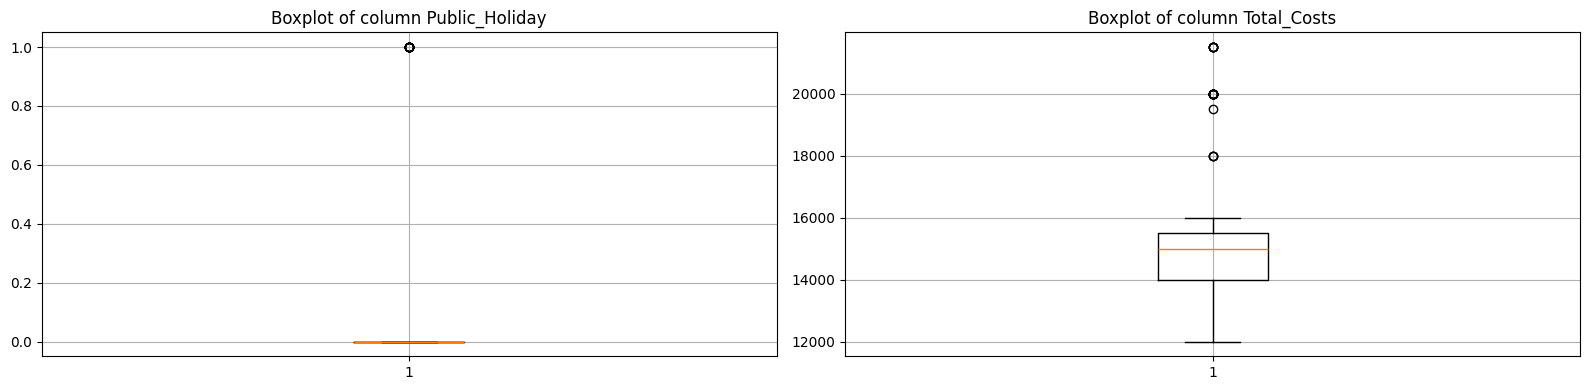

In [53]:
plt.figure(figsize=(16, 4))

for i, col in enumerate(df_outliers.columns):
    plt.subplot(1, 2, i +1)
    plt.boxplot(df_outliers[col])
    plt.title(f"Boxplot of column {col}")
    plt.grid(True)

plt.tight_layout()
plt.show()

In [31]:
display(df_outliers['Public_Holiday'].value_counts())
display(df_outliers['Total_Costs'].value_counts())

Public_Holiday
0    96
1    13
Name: count, dtype: int64

Total_Costs
15000    32
12000    16
14000    16
20000    16
15500     9
13000     9
21500     5
18000     3
16000     2
19500     1
Name: count, dtype: int64